# Face Recognition using Principal Component Analysis

Name: **Ashwin Sekhari** &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Roll Number: **117CS0263**

We intend to perform face recognition. Face recognition means that for a
given image you can tell the subject id. For our implmentation we will make use of the following 2 datasets:

1) https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/

2) http://cvit.iiit.ac.in/projects/IMFDB/

## Libraries

In [1]:
#Importing the required libraries to use later
import matplotlib.image as img
from numpy import linalg as LA
from scipy.spatial import distance
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

import math
import pickle
import operator
import os

#For debug
import logging
import sys
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.DEBUG, stream=sys.stdout)

#Comment this to enable logging
logging.disable()

We will not use any external libraries for this assignment and we will build PCA from scratch using the basic libraries. The following helper functions are used to aciheve our self sufficent goal.

## Helper functions

In [2]:
#Helper function to help us in classification tasks
def Test(data_mat0, data_mat1, label_mat0, label_mat1):
    '''
        This function expects omega i.e projected test face and Phi i.e Signature of each face
        and it then returns the accuracy of classfication for the test data.
    '''
    length = data_mat0.shape[0]
    map_ = np.zeros((1, length))
    
    #To store predicted labels for the testting data
    label_mat_new = np.zeros((1, length))
    
    #To store accuracy for the testing data
    accuracy_mat = np.ones((1, length))

    for i in range(0, length):
        for j in range(0, length):
            #Calculating eucledian distance between projected test data and signature of each face 
            map_[0, j] = distance.euclidean(data_mat1[i], data_mat0[j])
            
        #Assiging the label corresponding to the minimum distance 
        arg = map_.argmin()
        label_mat_new[0, i] = label_mat0[arg]
        if label_mat_new[0, i] != label_mat1[i]:
            #If predicted label and actual label don't match then it is not accurate and insert 0
            accuracy_mat[0, i] = 0
    return 100 * np.sum(accuracy_mat) / np.size(accuracy_mat)


In [3]:
def Train(data_matrix, k, str2):
    '''
        The function expects training data and a value k (number of selected feature vectors).
        This function performs all the required training steps.
    '''
    logging.debug(' Inside Train')
    isAlpha = False
    number = 0
    
    # Generating mean-zero delta (dimensions: mn*p)
    data_matrix_centered = data_matrix - np.mean(data_matrix, axis=0)
    logging.debug(' Generated Mean Zero')
    
    #Generating covariance of mean-zero delta (dimension: p*p)
    data_matrix_cov = np.cov(data_matrix_centered, rowvar=False)
    
    logging.debug(' Done with convariance')
    
    #Extracting EigenValue and EigenVector
    (eigenValues, eigenVectors) = LA.eigh(data_matrix_cov)
    idx = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:, idx]
    total = np.sum(eigenValues)

    logging.debug(' Extracting directions')
    #Extracting best direction and k value i.e getting a feature vector having dimnesion: p*k
    while isAlpha == False:
        sum_eigVal = 0.0
        for i in range(eigenValues.size):
            sum_eigVal = sum_eigVal + eigenValues[i] / total
            number += 1
            if math.isclose(sum_eigVal, k) or sum_eigVal > k:
                isAlpha = True
                break
    
    logging.debug(' Projection Matrix')
    #projection matrix containing Eigen faces of dimension: k*mn           
    projection_matrix = np.matrix([eigenVectors[n] for n in
                                  range(number)]).T

    logging.debug(' Saving objects....')
    #Saving the objects for future use in cache to save time during re-runs.
    if not Path(str2 + '.pickle').exists():
        with open(str2 + '.pickle', 'wb') as handle:
            pickle.dump(projection_matrix, handle,
                        protocol=pickle.HIGHEST_PROTOCOL)
    else:
        logging.warning(' '+str2+' Another file with same name already found.')
    return projection_matrix


In [4]:
def PCA(data_matrix, proj_matrix, k, str2):
    
    '''
    This generates Projection matrix the returned matrices
    have dimensions as k*1
    '''
    data_matrix_centered = data_matrix - np.mean(data_matrix, axis=0)
    if proj_matrix is None:
        #Call the train fucntion if no proj matrix exists
        logging.debug(' Before Train')
        projection_matrix = Train(data_matrix, k, str2)
        logging.debug(' After Train')
    else:
        projection_matrix = proj_matrix
        
    #Convert to eigen faces
    rd_data_matrix = np.matmul(data_matrix_centered, projection_matrix)
    return rd_data_matrix

## Generating the Data Matrix and their Labels

In [5]:
#Reading the images and storing them while maining the label structure
imgMat = np.zeros((0, 10304))
temp = np.arange(1, 41, 1) #We have 40 people

label_matrix = np.array([[temp[i]] * 10 for i in range(temp.size)])
label_matrix = label_matrix.flatten()

#Reading greyscale images form the ATT dataset
folder = 'ATT/'
for j in range(1, 41):
    direction = folder + 's' + str(j) + '/'
    for i in range(1, 11):
        directory = direction + str(i) + '.pgm'
        image = img.imread(directory).T
        imageVect = np.asmatrix(image.flatten())
        imgMat = np.concatenate((imgMat, imageVect))

## Spliting the Dataset into Training and Test sets 

In [6]:
test_data_matrix = imgMat[0:400:2]
training_data_matrix = imgMat[1:400:2]

label_test = label_matrix[0:400:2]
label_training = label_matrix[1:400:2]

## Results

K: 0.8 Accuracy = 71.5%

K: 0.81 Accuracy = 72.5%

K: 0.82 Accuracy = 70.5%

K: 0.83 Accuracy = 71.5%

K: 0.84 Accuracy = 75.5%

K: 0.85 Accuracy = 77.0%

K: 0.9 Accuracy = 83.0%

K: 0.91 Accuracy = 84.5%

K: 0.93 Accuracy = 88.0%

K: 0.95 Accuracy = 89.5%

K: 0.98 Accuracy = 90.5%

K: 0.99 Accuracy = 93.0%



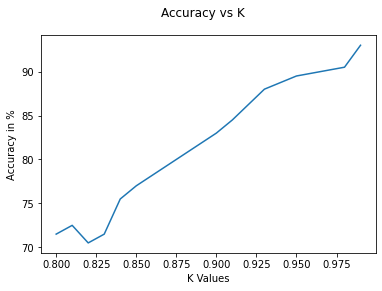

In [7]:
#Different k values to try
k_vals = [0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.9, 0.91, 0.93, 0.95, 0.98, 0.99]

logging.debug(k_vals)
k = np.matrix([k_vals])

acc_vals = []
for o in range(k.size):
    #Running a loop and checking it for all k values
    logging.debug(' K value ' +str(k[0,o]))
    proj_data_mat = None
    try:
        #Cached files to save time
        with open('proj_data_mat_' + str(k[0, o]) + '.pickle', 'rb') as handle:
            proj_data_mat = pickle.load(handle)
    except:
        pass
    try:
        training_data_matrix_rd = PCA(training_data_matrix, proj_data_mat,k[0, o], 'proj_data_mat_' + str(k[0, o]))
        logging.debug(' Done with training_data_matrix_rd')
        
        #Getting Eigen faces
        test_data_matrix_rd = PCA(test_data_matrix, proj_data_mat, k[0, o], 'proj_data_mat_' + str(k[0, o]))
        
        #getting and storing accuracy by testing data
        acc_prc = Test(training_data_matrix_rd, test_data_matrix_rd, label_training, label_test)
        acc_vals.append(acc_prc)
        print ('K: '+ str(k[0, o]) + ' Accuracy = ' + str(acc_prc) + '%\n')
    except:
        pass

logging.debug(acc_vals)
fig = plt.figure()
plt.plot(k_vals, acc_vals)
fig.suptitle('Accuracy vs K')
plt.xlabel('K Values')
plt.ylabel('Accuracy in %')
plt.show()